In [361]:
import math
import numpy as np

import mido
import librosa
import librosa.display

import IPython.display as ipd
import matplotlib.pyplot as plt
from torch import optim

import torch.nn.functional as F
from torch import nn
import torch

windowSize=50

In [411]:
y, sr = librosa.load('4Beats2MelLong3.wav')

In [412]:
D = librosa.stft(y)

In [413]:
#ipd.Audio(y_hat,rate=sr) # load a local WAV file
ipd.Audio(y,rate=sr) # load a local WAV file

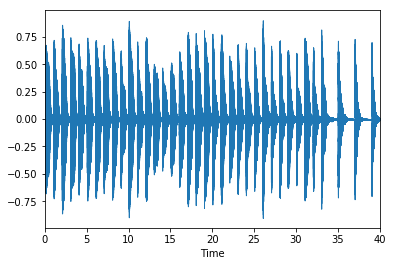

In [414]:
librosa.display.waveplot(y, sr=sr);

In [415]:
midiArray=[]
HopSize=0.023
timeTracker=0.0
totalTimeTracker=0.0
MemoryArray=np.zeros(128)
lasttime=0;
bpm=60
for msg in mido.MidiFile('4Beats2MelLong3.mid'):
    if not msg.is_meta:
        totalTimeTracker+=msg.time
        nextEventTime=lasttime+msg.time
        while nextEventTime> timeTracker + HopSize:
            MemoryArray[127]=((timeTracker%4) * (bpm/60.0))/4.0
            midiArray.append(MemoryArray.copy())
            timeTracker += HopSize;
        if msg.type=='note_on':
            MemoryArray[msg.note]+=1.0;
        elif msg.type=='note_off':
            MemoryArray[msg.note]-=1.0;
        if(timeTracker+msg.time >= timeTracker + HopSize):
            MemoryArray[127]=((timeTracker%4) * (bpm/60.0))/4.0
            midiArray.append(MemoryArray.copy())
            timeTracker += HopSize
        lasttime += msg.time
    else:
        if(msg.type == 'set_tempo'):
            bpm=60000000/msg.tempo
        

(1723, 1025) (1718, 128)


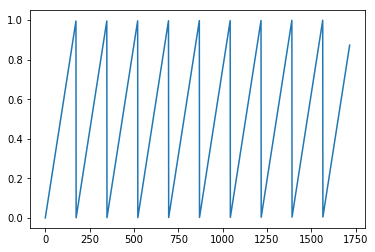

[0.      0.00575 0.0115  ... 0.86125 0.867   0.87275]


In [416]:
midiArray=np.float32(np.array(midiArray))
D_t=D.T
print(D_t.shape,midiArray.shape)
plt.plot(midiArray[:,127])
plt.show()
print(midiArray[:,127])

In [417]:
minLength = min(midiArray.shape[0],D_t.real.shape[0])

D_data=D_t[:minLength].real;
midiArray=midiArray[:minLength];
print(midiArray.shape,D_data.shape)
print(midiArray.dtype,D_data.dtype)

(1718, 128) (1718, 1025)
float32 float32


In [418]:

outPutMidiArray=[]
for i in range(midiArray.shape[0]):
    temp=[]
    for j in range(windowSize):
        val = int(j-(np.floor(windowSize/2)))
        val = i+val
        if(val<0 or val+1>midiArray.shape[0]):
             temp.append(np.zeros(midiArray.shape[1]))
        else:
            temp.append(midiArray[val])
    outPutMidiArray.append(temp)
outPutMidiArray=np.array(outPutMidiArray)

In [419]:
print(outPutMidiArray.shape)

(1718, 50, 128)


In [385]:
## Solution

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the layers, 128, 64, 10 units each
        self.fc1 = nn.Linear(128*windowSize, int(128*windowSize/2))
        self.fc2 = nn.Linear(int(128*windowSize/2), 1000)
        self.fc3 = nn.Linear(1000, 1025)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        return x

model = Network()
model

Network(
  (fc1): Linear(in_features=6400, out_features=3200, bias=True)
  (fc2): Linear(in_features=3200, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=1025, bias=True)
)

In [386]:
tensor_x.shape

torch.Size([501, 6400])

In [420]:
import torch.utils.data as utils


tensor_x = torch.stack([torch.Tensor(i) for i in np.abs(outPutMidiArray)]) # transform to torch tensors
tensor_y = torch.stack([torch.Tensor(i) for i in np.abs(D_data)])
tensor_x = tensor_x.view(tensor_x.shape[0],-1)
print(tensor_x.shape,tensor_y.shape)
my_dataset = utils.TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = utils.DataLoader(my_dataset,batch_size=64,shuffle=True) # create your dataloader

my_testloader = utils.DataLoader(my_dataset) # create your dataloader


# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

criterion = nn.MSELoss()
# or criterion = nn.MSELoss()
# Get our data


torch.Size([1718, 6400]) torch.Size([1718, 1025])


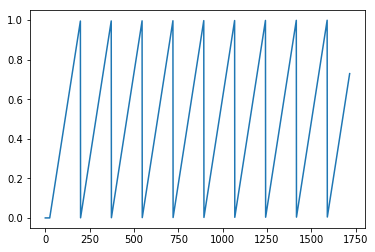

In [421]:
plt.plot(tensor_x.numpy()[:,127])
plt.show()

In [389]:
##Reset
Counter=0;
LossOverEpoch=[]
model.train()

Network(
  (fc1): Linear(in_features=6400, out_features=3200, bias=True)
  (fc2): Linear(in_features=3200, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=1025, bias=True)
)

In [422]:
model.train()

Network(
  (fc1): Linear(in_features=6400, out_features=3200, bias=True)
  (fc2): Linear(in_features=3200, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=1025, bias=True)
)

In [451]:
epochs = 500
for i in range(epochs):
    running_loss = 0
    for data, labels in my_dataloader:
        optimizer.zero_grad()     
        logits = model(data)
        loss =criterion(logits,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    else:
        LossOverEpoch.append(running_loss)
        print(f"Training loss: {running_loss/len(my_dataloader)}" +"   "+ str(Counter))
        Counter+=1

Training loss: 1.565363813329626   2771
Training loss: 1.5614705129905984   2772
Training loss: 1.562825291245072   2773
Training loss: 1.562142182279516   2774
Training loss: 1.566081894768609   2775
Training loss: 1.56235788486622   2776
Training loss: 1.5599308234673959   2777
Training loss: 1.5654393037160237   2778
Training loss: 1.5592319038179185   2779
Training loss: 1.5599442565882649   2780
Training loss: 1.5598434563036319   2781
Training loss: 1.5592047108544245   2782
Training loss: 1.5584623173431114   2783
Training loss: 1.5579794380399916   2784
Training loss: 1.5546350721959714   2785
Training loss: 1.5534915615011144   2786
Training loss: 1.5586110397621438   2787
Training loss: 1.5558422053301777   2788
Training loss: 1.5564650142634358   2789
Training loss: 1.5547102115772389   2790
Training loss: 1.5547885629865859   2791
Training loss: 1.5530384911431208   2792
Training loss: 1.5521964011368927   2793
Training loss: 1.5521879063712225   2794
Training loss: 1.55397

Training loss: 1.4683358580977828   2972
Training loss: 1.4662627379099529   2973
Training loss: 1.4713147591661524   2974
Training loss: 1.4686823001614324   2975
Training loss: 1.467172055332749   2976
Training loss: 1.4651782623043768   2977
Training loss: 1.4647837788970381   2978
Training loss: 1.4664617202900074   2979
Training loss: 1.4628134347774364   2980
Training loss: 1.4681080005787037   2981
Training loss: 1.4643106151510168   2982
Training loss: 1.4642389306315668   2983
Training loss: 1.4627737689901281   2984
Training loss: 1.4611462663721155   2985
Training loss: 1.4623655014567905   2986
Training loss: 1.4604128268029954   2987
Training loss: 1.4621671195383426   2988
Training loss: 1.4619960762836315   2989
Training loss: 1.4698860579066806   2990
Training loss: 1.4655449368335582   2991
Training loss: 1.4588567702858537   2992
Training loss: 1.4619061902717307   2993
Training loss: 1.459102036776366   2994
Training loss: 1.4586658080418904   2995
Training loss: 1.4

Training loss: 1.3906092621661998   3174
Training loss: 1.3938048106652718   3175
Training loss: 1.3909243146578472   3176
Training loss: 1.3896028840983357   3177
Training loss: 1.3915737160929926   3178
Training loss: 1.391317742842215   3179
Training loss: 1.3882445141121194   3180
Training loss: 1.3888733938888267   3181
Training loss: 1.3900252779324849   3182
Training loss: 1.3866297602653503   3183
Training loss: 1.3850530209364715   3184
Training loss: 1.3885531226793926   3185
Training loss: 1.3841582161408883   3186
Training loss: 1.3879349651160064   3187
Training loss: 1.3899474364739877   3188
Training loss: 1.3855319619178772   3189
Training loss: 1.3817416893111334   3190
Training loss: 1.3863839595406144   3191
Training loss: 1.3855792946285672   3192
Training loss: 1.3827868920785409   3193
Training loss: 1.381018097753878   3194
Training loss: 1.3835656996126529   3195
Training loss: 1.3831583239414074   3196
Training loss: 1.3838232336220917   3197
Training loss: 1.3

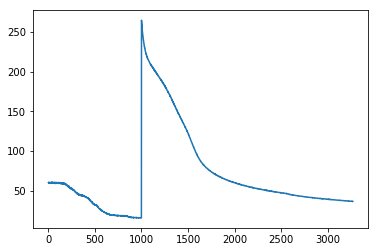

In [467]:
plt.plot(LossOverEpoch)
plt.show()
#torch.save(model.state_dict(), './w10-3270Epochs.model')

In [454]:
model.eval()
outputArray=[]
for data, labels in my_testloader:
    with torch.no_grad():
        output = model.forward(data)
        outputArray.append(output[0].numpy())
outputArray=np.array(outputArray).T

In [455]:
print((outputArray).shape)
Y_infered = librosa.istft(outputArray) 

(1025, 1718)


In [456]:
ipd.Audio(Y_infered,rate=sr)

In [457]:
ipd.Audio(y,rate=sr)

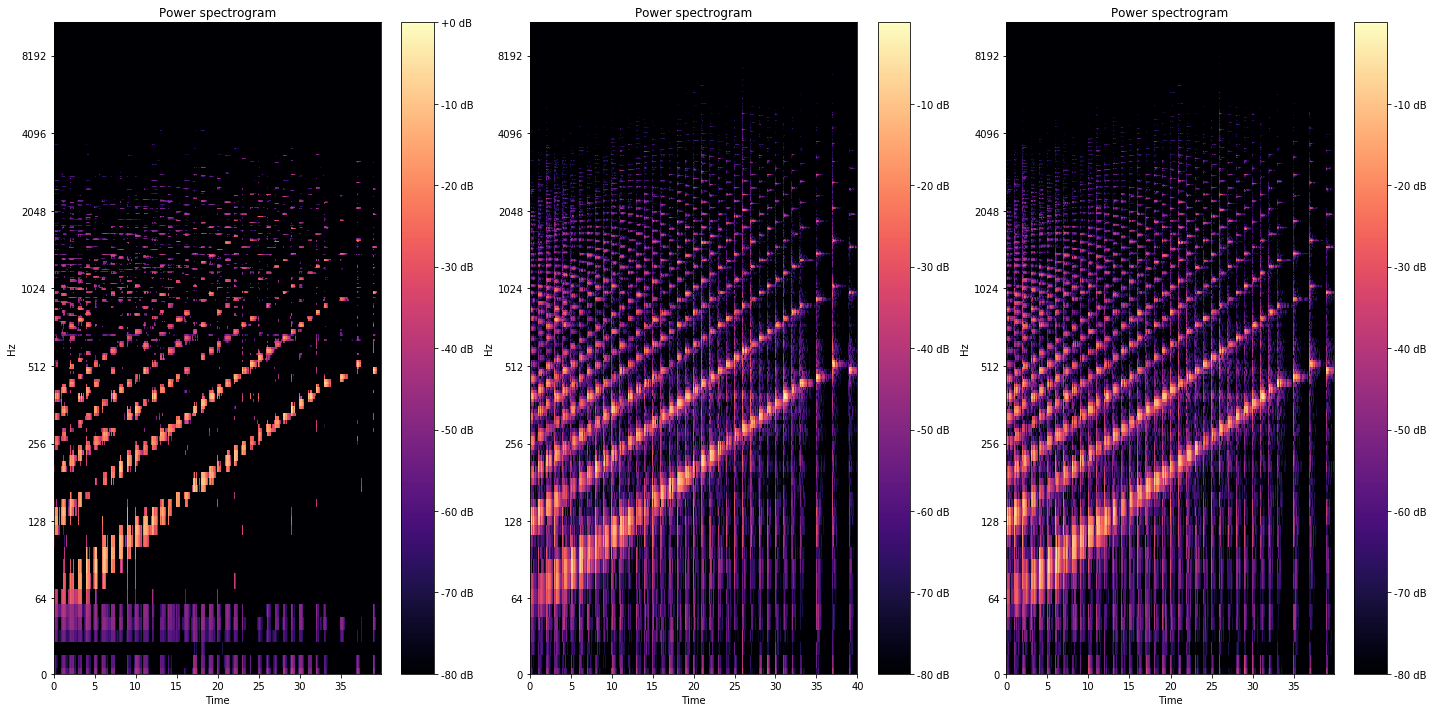

In [458]:

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
librosa.display.specshow(librosa.amplitude_to_db(outputArray,
                                                  ref=np.max),
                          y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

plt.subplot(1,3,2)
librosa.display.specshow(librosa.amplitude_to_db(D.real,
                                                  ref=np.max),
                          y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()


plt.subplot(1,3,3)
librosa.display.specshow(librosa.amplitude_to_db(tensor_y.numpy().T,
                                                  ref=np.max),
                          y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()


0.02149372361600399
(1025,) (1025,)


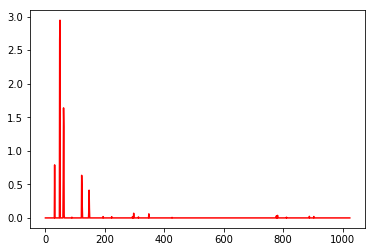

In [463]:
output=np.array(0);
with torch.no_grad():
        test=torch.zeros([1, 128*windowSize], dtype=torch.float32)
       # test[0][46]=0.0;
        output = model.forward(test)
      #  test2=torch.ones([1, 1025], dtype=torch.float32)
      #  test2[0][46]=0.0;
        loss = criterion(output,torch.zeros([1, 1025], dtype=torch.float32))
        print(loss.item())
print(output.numpy()[0].shape,D_data[250].shape)
plt.plot(output.numpy()[0],'r')
#plt.plot(D_data[250],'g')
plt.show()

In [464]:
print(output.numpy()[0].shape)

(1025,)


(1025, 501)


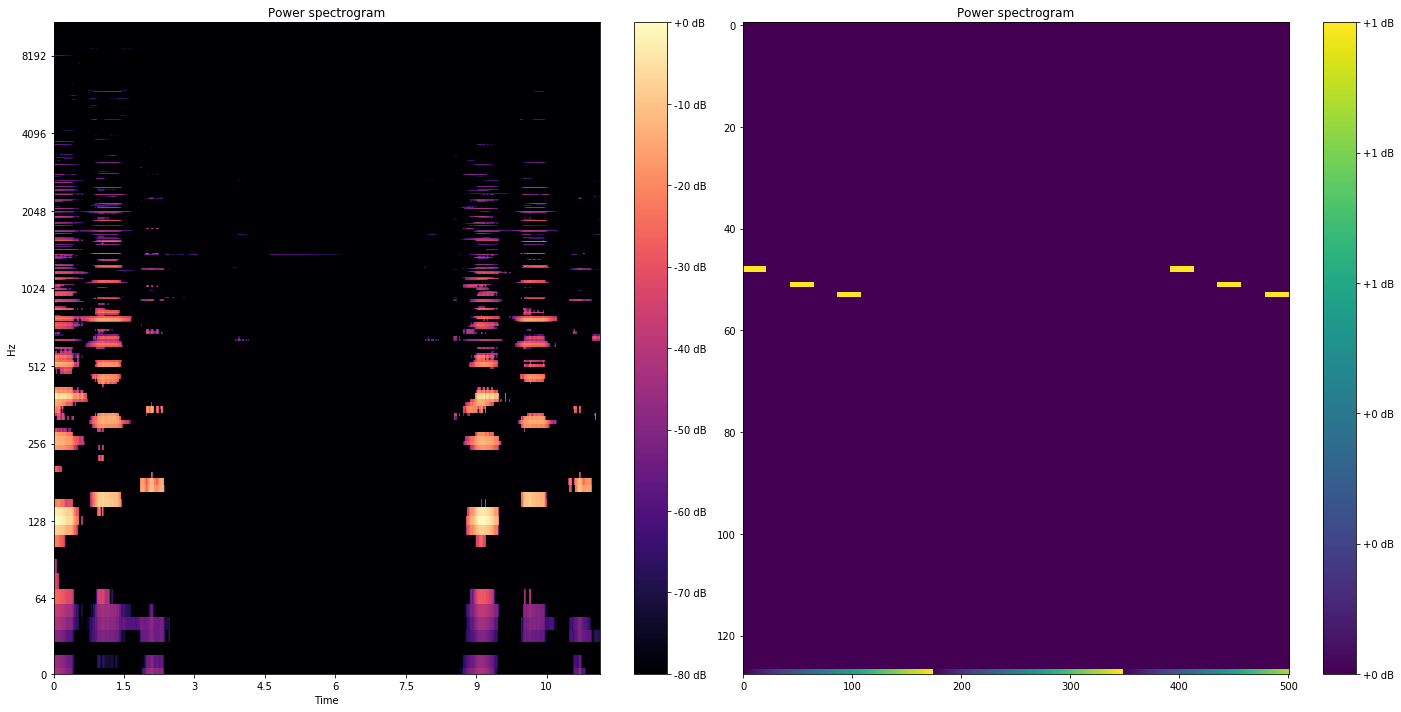

In [465]:
midiTestArray=[]
HopSize=0.023
timeTracker=0.0
totalTimeTracker=0.0
MemoryArray=np.zeros(128)
lasttime=0;
bpm=60
for msg in mido.MidiFile('4Beats2Mel.mid'):
    if not msg.is_meta:
        totalTimeTracker+=msg.time
        nextEventTime=lasttime+msg.time
        while nextEventTime> timeTracker + HopSize:
            MemoryArray[127]=((timeTracker%4) * (bpm/60.0))/4.0
            midiTestArray.append(MemoryArray.copy())
            timeTracker += HopSize;
        if msg.type=='note_on':
            MemoryArray[msg.note]+=1.0;
        elif msg.type=='note_off':
            MemoryArray[msg.note]-=1.0;
        if(timeTracker+msg.time >= timeTracker + HopSize):
            MemoryArray[127]=((timeTracker%4) * (bpm/60.0))/4.0
            midiTestArray.append(MemoryArray.copy())
            timeTracker += HopSize
        lasttime += msg.time
    else:
        if(msg.type == 'set_tempo'):
            bpm=60000000/msg.tempo
midiTestArray = np.float32(np.array(midiTestArray))

MainMidiTest=[]
for i in range(midiTestArray.shape[0]):
    temp=[]
    for j in range(windowSize):
        val = int(j-(np.floor(windowSize/2)))
        val = i+val
        if(val<0 or val+1>midiTestArray.shape[0]):
             temp.append(np.zeros(midiTestArray.shape[1]))
        else:
            temp.append(midiTestArray[val])
    MainMidiTest.append(temp)
MainMidiTest=np.array(MainMidiTest)



tensor_x_test = torch.stack([torch.Tensor(i) for i in np.abs(MainMidiTest)])
tensor_x_test = tensor_x_test.view(tensor_x_test.shape[0],-1)

testDataSet = utils.TensorDataset(tensor_x_test,torch.zeros(tensor_x_test.shape)) # create your datset
TestLoader = utils.DataLoader(testDataSet) # create your dataloader


model.eval()
outputArray=[]
for data, labels in TestLoader:
    with torch.no_grad():
        output = model.forward(data)
        outputArray.append(output[0].numpy())
outputArray=np.array(outputArray).T
print((outputArray).shape)
Y_infered2 = librosa.istft(outputArray) 

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(outputArray,
                                                  ref=np.max),
                          y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

plt.subplot(1,2,2)
plt.imshow(midiTestArray.T,interpolation='nearest', aspect='auto')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

plt.show();


ipd.Audio(Y_infered2,rate=sr)

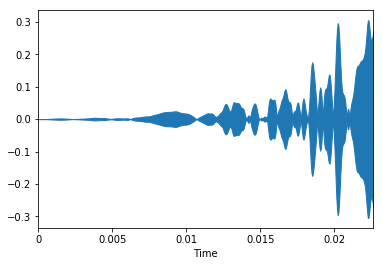

In [466]:
librosa.display.waveplot(y[:500], sr=sr);